# Data Science Callenge
This challenge uses 4 years of power consumption measurements of a single household with one-minute intervals of sampling.  The data is available here:
http://archive.ics.uci.edu/ml/datasets/Individual+household+electric+power+consumption

The challenge is accompanied by the following list of questions, for which responses are underneath:

1. How do you handle the data? 
    * All data is wrangled with the `pandas` package in python.  Analysis is done using various python packages.  Although minute-by-minute data is provided, the challenge asks that we only make predictions using data upto the preceding hour.  This constraint is conveniently satisfied by simply confining the data set to hourly intervals.  Since there is a large amount of data available, the models we build are unlikely to be greatly affected by this approach of dropping data.
    
2. What analysis do you run to understand the features? 
    * Basic stats (mean, std), time-series plots of the features/outputs, histograms, and correlation plots.  This is important when verifying the validity of the imputing step.  A very strong linear correlation was found between the Global_average_power and Global_intensity.  Voltage measurements appear Gaussian with a peak just above 240 V, so it's likely the data was recorded from a UK home. 

3. What do you do with missing or incorrect values? 
    * Through trial-and-error, we find that missing values are stored as '?', which can be immediately picked up by `pandas`.  They are then filled using the preceding value in the series, though they may be imputed using mean values as well.  Using forward fill is better than mean imputation since the minute-by-minute variation is quite small (verified by the RMSE of a persistent model using minute-sampling data).  The time-series of the Global_active_power is plotted before and after imputing to check for any outlying values when imputing from the mean.   
        
4. What type of model do you use, and why? 
    * Two models were investigated:
        * __ARMA__: This is a standard time-series model built on autogregression (using a number of preceding values (lag $\approx$ 50 below) as inputs) and moving averages.  After experimenting a bit, we found the AR model worked best.  It is quick to train and implement with no tuning parameters.
        * __LSTM Neural Network__: Neural nets are a much publicized learning algorithm which, in prinicple, require no a-priori modeling.  In this analysis, we experimented with a few LSTM architectures with a casual approach to hyper-parameter tuning.
        
5. What metric do you use to evaluate the model? 
    * The evaluation metric employed was the root mean square error:
    $$ \text{RMSE} = \frac{\sqrt{\sum_{n=1}^{n=N}(y_i - \hat{y}(t_i))^2}}{N-1}$$
    
6. What baseline do you compare it against? 
    * The persistent model:
        $$\hat{y}(t_i+1 \text{ hour}) = y_i,$$
        which yields $\text{RMSE}_p = 1.041$.  The RMSE of the trained models are
        * __ARMA__: 0.847
        * __LSTM NN__: 0.790 - 0.820

    Our model represents more than a 15% improvement over the baseline (presistent model), with the neural net performing a couple of percent better.

## Load libraries and data

In [1]:
## load libraries
# %matplotlib notebook
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import datetime as dt

In [2]:
## load data
file_name = 'household_power_consumption.zip'
    # ensure the text is converted appropriately to floats
dtypes = {'Data': str, 'Time': str, 'Global_active_power': float, 'Global_reactive_power': float,
         'Voltage': float, 'Global_intensity': float, 'Sub_metering_1': float,
          'Sub_metering_2': float, 'Sub_metering_3': float}
data_df = pd.read_csv(file_name, compression='infer', sep=';', na_values='?', dtype=dtypes)
new_names = {'Sub_metering_1': 'Kitchen', 'Sub_metering_2': 'Laundry', 
             'Sub_metering_3': 'Water_AC'}
data_df.rename(columns=new_names, inplace=True)

    # load various subsets of the data
data_df = data_df.iloc[::60, :] # get hourly data
# data_df = data_df.iloc[15000:, :] # the later half of the data
# data_df = data_df.iloc[::60*24, :] # get daily data
# data_df = data_df.iloc[-50*24*60:, :] # get last 15 days of data
# data_df = data_df.sample(frac=0.10) # get random sample of data

data_df.head(n=2)

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Kitchen,Laundry,Water_AC
0,16/12/2006,17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
60,16/12/2006,18:24:00,3.452,0.000,235.20,15.2,0.0,1.0,17.0


In [3]:
## create datetime object as a feature
data_df['DateTime'] = data_df[['Date','Time']].apply(
    lambda d: d[0] + ' ' + d[1], axis=1)
data_df['DateTime'] = data_df['DateTime'].apply(
    lambda x: dt.datetime.strptime(x, '%d/%m/%Y %H:%M:%S'))
tmp_data = pd.DataFrame(data_df.pop('DateTime'))
data_df = tmp_data.join(data_df)
data_df.sort_values(by='DateTime', inplace=True)
    # keep a subset of the data past some start date
# start_date = dt.datetime(year=2010, month=1, day=1)
# data_df = data_df[ data_df.DateTime > start_date ]
data_df.head(n=2)

,DateTime,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Kitchen,Laundry,Water_AC
0,2006-12-16 17:24:00,16/12/2006,17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
60,2006-12-16 18:24:00,16/12/2006,18:24:00,3.452,0.000,235.20,15.2,0.0,1.0,17.0


In [4]:
## check how many missing values are around
count_nan = len(data_df) - data_df.count()
count_nan

DateTime                   0
Date                       0
Time                       0
Global_active_power      434
Global_reactive_power    434
Voltage                  434
Global_intensity         434
Kitchen                  434
Laundry                  434
Water_AC                 434
dtype: int64

## Data/feature exploration

In [5]:
## check means and stds to see if they look like meaningful numbers
data_df.describe()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Kitchen,Laundry,Water_AC
count,34154.000000,34154.000000,34154.000000,34154.000000,34154.000000,34154.000000,34154.000000
mean,1.082061,0.123703,240.901411,4.586514,1.117849,1.304562,6.408444
std,1.049330,0.112404,3.220452,4.410786,6.122154,5.788137,8.413045
min,0.078000,0.000000,225.320000,0.200000,0.000000,0.000000,0.000000
25%,0.308000,0.048000,239.110000,1.400000,0.000000,0.000000,0.000000
50%,0.590000,0.100000,241.060000,2.600000,0.000000,0.000000,1.000000
75%,1.524000,0.194000,242.920000,6.400000,0.000000,1.000000,17.000000
max,10.290000,0.982000,253.360000,44.600000,80.000000,76.000000,31.000000


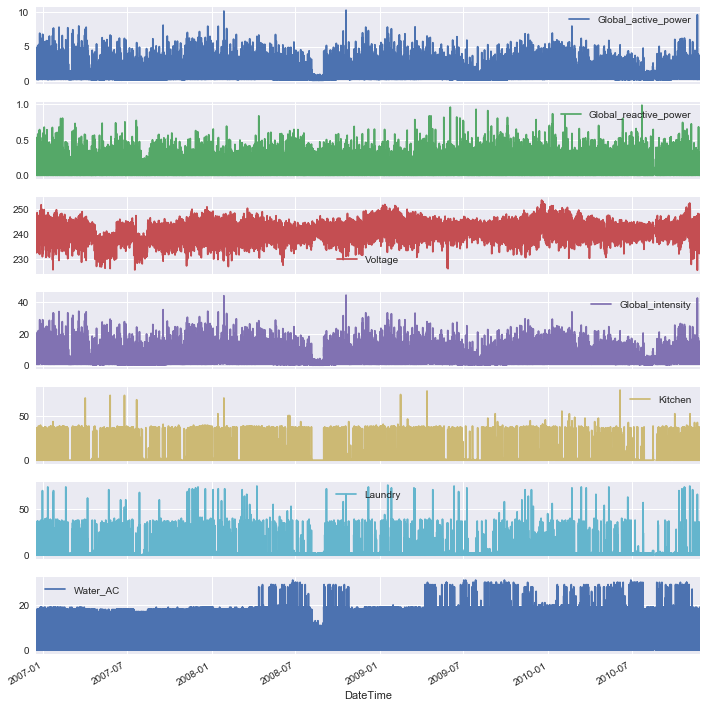

In [6]:
## plot Global_active_power and features against time
data_df.plot(x='DateTime', subplots=True, figsize=(10,10))
plt.tight_layout()
plt.show()

In [7]:
## impute missing values
from sklearn.preprocessing import Imputer

impute_method = 'forward_fill' # 'mean' or 'forward_fill' (preceding value)

if impute_method == 'mean':
    feature_list = [c for c in data_df.columns if c not in ['Date', 'Time', 'DateTime']]
    for feature in feature_list:
        imputer = Imputer(missing_values=np.nan, strategy='mean')
        data_df[feature] = imputer.fit_transform(data_df[feature].values.reshape(-1, 1))
elif impute_method == 'forward_fill':
    data_df.fillna(method='ffill', inplace=True)
else:
    print('Choose a proper imputing method.')

In [8]:
count_nan = len(data_df) - data_df.count()
if count_nan.sum() != 0:
    print('There are {:d} more missing values to deal with.'.format(count_nan.sum()))

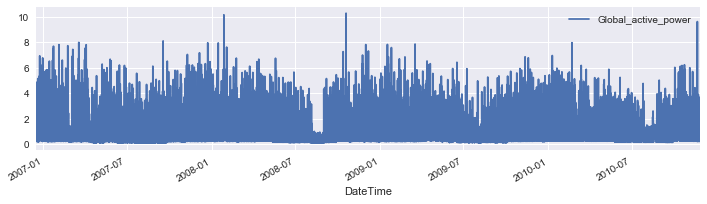

In [9]:
## plot Global_active_power again to make sure imputing didn't create any spurious behaviour
data_df.plot(x='DateTime', y='Global_active_power', figsize=(10,3))
plt.tight_layout()
plt.show()

## Explore correlation between features/output

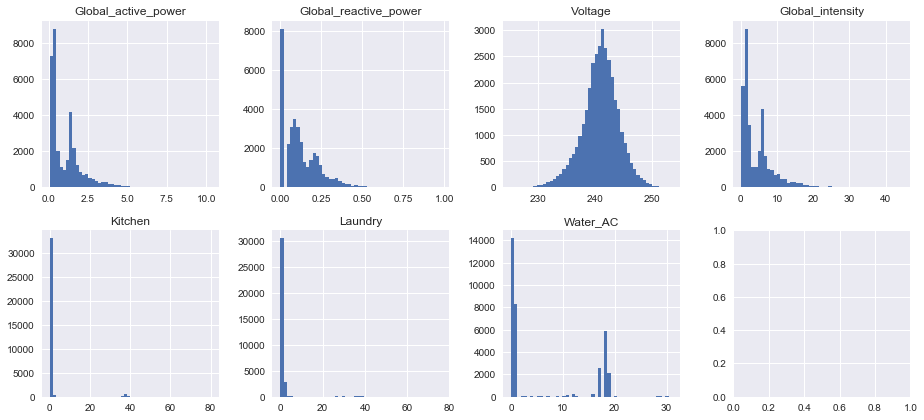

In [10]:
## plot histograms of each feature
feature_list = [c for c in data_df.columns if c not in ['Date', 'Time', 'DateTime']]
n_features = len(feature_list)
fig, ax = plt.subplots(nrows=int(np.ceil(n_features/4)), 
                       ncols=4, figsize=(13,6), squeeze=True)
ax = ax.ravel()
nplot = 0
for feature in feature_list:
    ax[nplot].hist(data_df[feature], bins=50, normed=False)
    ax[nplot].set_title(feature)
    nplot = nplot + 1

plt.tight_layout()
plt.show()

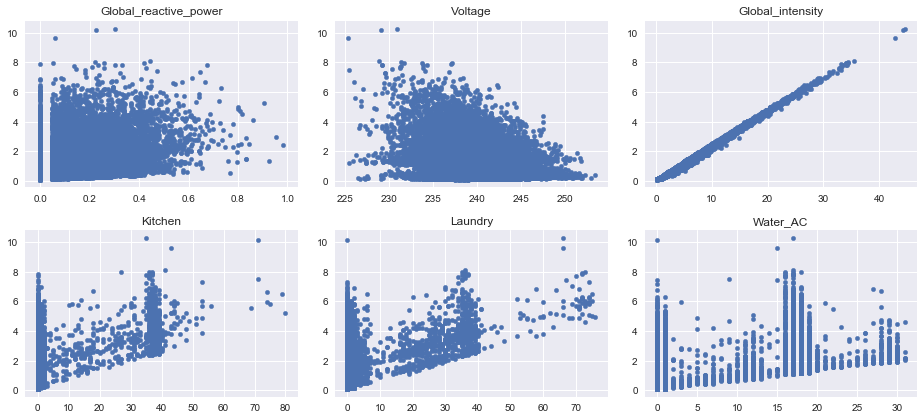

In [11]:
## scatter plot of each feature against the target
feature_list = [c for c in data_df.columns if c not in ['Date', 'Time', 'DateTime',
                                                       'Global_active_power']]
n_features = len(feature_list)
fig, ax = plt.subplots(nrows=int(np.ceil(n_features/3)), 
                       ncols=3, figsize=(13,6), squeeze=True)
ax = ax.ravel()
nplot = 0
for feature in feature_list:
    ax[nplot].scatter(data_df[feature], data_df.Global_active_power, s=20)
    ax[nplot].set_title(feature)
    nplot = nplot + 1

plt.tight_layout()
plt.show()

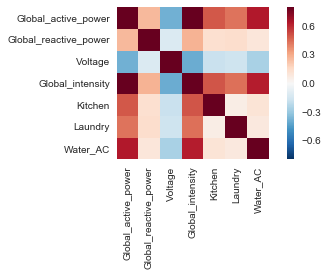

In [12]:
## heatmap of correlation matrix
corrmat = data_df.corr()
fig, ax = plt.subplots(figsize=(6, 4))
sns.heatmap(corrmat, vmax=.8, square=True)
plt.tight_layout()
plt.show()

## Autoregression Models

In [13]:
## create time series for predicted output and prediction time stamps
data_ts = data_df['Global_active_power']
data_ts.index = data_df.DateTime

            t       t+1
t    1.000000  0.509093
t+1  0.509093  1.000000


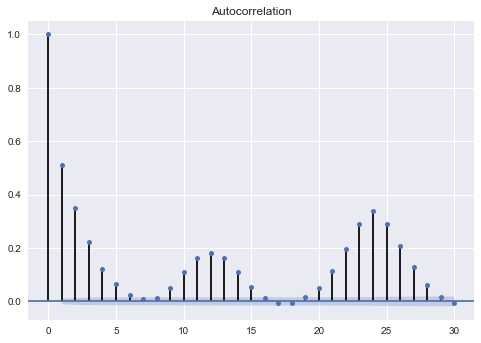

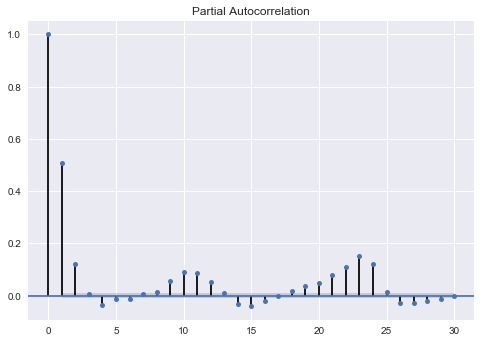

ADF Statistic: -14.954898
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567


In [14]:
## check autocorrelation
from pandas.tools.plotting import autocorrelation_plot, lag_plot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller

values = pd.DataFrame(data_ts)
df = pd.concat([values.shift(1), values], axis=1)
df.columns = ['t', 't+1']
result = df.corr()
print(result)

# lag_plot(data_ts)
# plt.show()

# autocorrelation_plot(data_ts)
# plt.show()

plot_acf(data_ts, lags=30)
plt.show()

plot_pacf(data_ts, lags=30)
plt.show()

# check if stationary
result = adfuller(data_ts)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

# since adf statistics is less than the 1% critical value, we reject
# the null hypothesis.  This means there is no unit run and the 
# time series is stationary: there are not time-dependent structures
# one level of differencing, so d =>1 in ARIMA



In [15]:
## build and test the model
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima_model import ARMA
from sklearn.metrics import mean_squared_error

# experiment with AR and MA models
model = AR(data_ts, missing='raise') # rmse = 0.847
# model = ARMA(data_ts, (2,2)) # rmse = 0.889
# model = ARIMA(data_ts, order=(10, 0, 2), missing='raise')
model = model.fit()
lag = model.k_ar
print('Lag: %s' % lag)

# make predictions
pred_times = data_ts.index[lag:]
pred = model.predict(start=pred_times[0], end=pred_times[-1], dynamic=False)
rmse = np.sqrt(mean_squared_error(data_ts.values[lag:] , pred.values))
rmse_persistent = np.sqrt(mean_squared_error(data_ts.values[lag:-1],
                                            data_ts.values[lag+1:]))
print('RMSE: {:0.3f}'.format(rmse))
print('RMSE Persistent: {:0.3f}'.format(rmse_persistent))


Lag: 52
RMSE: 0.847
RMSE Persistent: 1.041


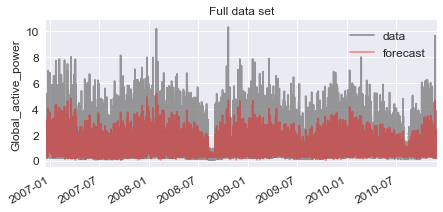

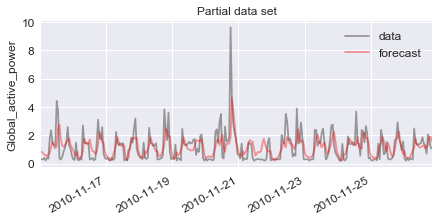

In [16]:
## plot the data
def plot_data(start_date, title='figure'):
    ax = data_ts[ data_ts.index > start_date ].plot(
        color='grey', alpha=0.8, figsize=(7,3), fontsize=12)
    pred[ pred.index > start_date ].plot(color='red', alpha=0.4)
    ax.legend(['data', 'forecast'], fontsize=12)
    ax.set_ylabel('Global_active_power', fontsize=12)
    ax.set_xlabel('')
    ax.set_title(title, fontsize=12)
    file_name = title.replace(' ','_').lower() + '.png'
    plt.savefig(file_name, orientation='landscape',format='png')
    plt.show()
    

start_date = dt.datetime(year=2005, month=1, day=1, hour=1, minute=1)
plot_data(start_date, title='Full data set')
start_date = dt.datetime(year=2010, month=11, day=15, hour=1, minute=1)
plot_data(start_date, title='Partial data set')

## LSTM Net Model
Tips available here:
http://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/

In [17]:
## load modules for building neural net
from keras.models import Sequential
from keras.layers import Dense, LSTM, Activation
from sklearn.preprocessing import MinMaxScaler

Using TensorFlow backend.


In [18]:
## pre-process data

# scale data for NN activation functions
scaler = MinMaxScaler(feature_range=(0,1))

# reshape : (-1,1) for a single feature.  (1,-1) for single sample
data_values = data_ts.values.astype('float32').reshape(-1,1)
data_values = scaler.fit_transform(data_values)

# split into train and test set
train_size = int(len(data_values) * 1/2)
test_size = len(data_values) - train_size
train, test = data_values[0:train_size], data_values[train_size:]
print(len(train), len(test))

17294 17294


In [19]:
## create features to data set (preceding values for regression)
def create_dataset(dataset, look_back=1):
    features, target = [], []
    for i in range(0, len(dataset)-look_back-1):
        features.append( dataset[i:(i+look_back),0] )
        target.append( dataset[i+look_back,0] )
    return np.array(features), np.array(target)

look_back = 24*21
trainX, trainY = create_dataset(train, look_back=look_back)
testX, testY = create_dataset(test, look_back=look_back)

# reshape for keras input: [samples, time steps, features]
# time step = look_back = number of previous steps to include
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [20]:
# ## create and fit LSTM network with 4 neurons in 1 layer
batch_size = 11 # must be factor of number of samples
model = Sequential()

# build/experiment with the network
    # 4-neuron hidden layer, default LSTM activation = 'tanh'
# model.add(LSTM(4, input_dim=look_back, return_sequences=False))
    # 3 hidden layers with drop out
model.add(LSTM(32, input_dim=look_back, return_sequences=True,
               dropout_U=0.2, dropout_W=0.2))
model.add(LSTM(16, return_sequences=True, dropout_U=0.2, dropout_W=0.2))
model.add(LSTM(4, return_sequences=False))

model.add(Dense(1, activation='relu')) # default activation = linear
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, nb_epoch=20, batch_size=16, verbose=0)


## LSTM with memory (doesn't perform so well)
# model = Sequential()
# model.add(LSTM(64, batch_input_shape=(batch_size, 1, look_back),
#                stateful=True, return_sequences=True,
#                dropout_U=0.25, dropout_W=0.25))
# model.add(LSTM(32, batch_input_shape=(batch_size, 1, look_back),
#                stateful=True, return_sequences=True,
#                dropout_U=0.25, dropout_W=0.25))
# model.add(LSTM(8, batch_input_shape=(batch_size, 1, look_back),
#                stateful=True))
# model.add(Dense(1))
# model.compile(loss='mean_squared_error', optimizer='adam')
# for i in range(40):
#     model.fit(trainX, trainY, nb_epoch=1, batch_size=batch_size, verbose=2, shuffle=False)
#     model.reset_states()

In [21]:
## make predictions and unscale
train_pred = model.predict(trainX, batch_size=batch_size)
train_pred = scaler.inverse_transform(train_pred)
trainY = scaler.inverse_transform([trainY])
# model.reset_states() # use if stateful memory
test_pred = model.predict(testX, batch_size=batch_size)
test_pred = scaler.inverse_transform(test_pred)
testY = scaler.inverse_transform([testY])

In [22]:
## test predictions
trainScore = np.sqrt(mean_squared_error(trainY[0,:], train_pred[:,0]))
print('Train Score: {:.3f} RMSE'.format(trainScore))
testScore = np.sqrt(mean_squared_error(testY[0,:], test_pred[:,0]))
print('Test Score: {:.3f} RMSE'.format(testScore))

Train Score: 0.712 RMSE
Test Score: 0.793 RMSE


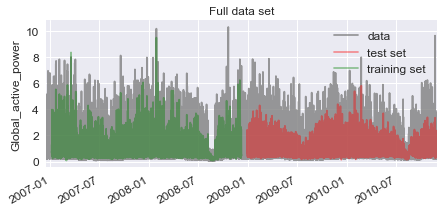

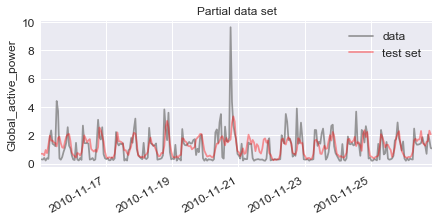

In [23]:
## plot the data
# convert NN output to pandas time series with proper dates
train_plot = pd.Series(train_pred[:,0], index=data_ts.index[
        look_back:len(train_pred)+look_back])
test_plot = pd.Series(test_pred[:,0], index=data_ts.index[
        len(train_pred)+(2*look_back)+1:len(data_values)-1])

def plot_data(start_date, title='figure'):
    ax = data_ts[ data_ts.index > start_date ].plot(
        color='grey', alpha=0.8, figsize=(7,3), fontsize=12)
    test_plot[ test_plot.index > start_date ].plot(color='red', alpha=0.4)
    try:
        train_plot[ train_plot.index > start_date ].plot(color='green', alpha=0.4)
    except:
        pass
    ax.legend(['data', 'test set', 'training set'], fontsize=12)
    ax.set_ylabel('Global_active_power', fontsize=12)
    ax.set_xlabel('')
    ax.set_title(title, fontsize=12)
    file_name = title.replace(' ','_').lower() + '.png'
    plt.savefig(file_name, orientation='landscape',format='png')
    plt.show()
    
start_date = dt.datetime(year=2005, month=1, day=1, hour=1, minute=1)
plot_data(start_date, title='Full data set')
start_date = dt.datetime(year=2010, month=11, day=15, hour=1, minute=1)
plot_data(start_date, title='Partial data set')